In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
%matplotlib notebook

In [2]:
# Load data
data = pickle.load(open("../../Data/Wandercraft_id/20200925T110815Z_LogFile_temporal.pickle", "rb"))
u = data["torque"]
theta = data["encoder"]
w_foot = data["gyro"]
w_pelvis = data["gyro_pelvis"]
w = [data["gyro"][i] - data["gyro_pelvis"][i] for i in range(len(u))]
dt = 1e-3

<IPython.core.display.Javascript object>


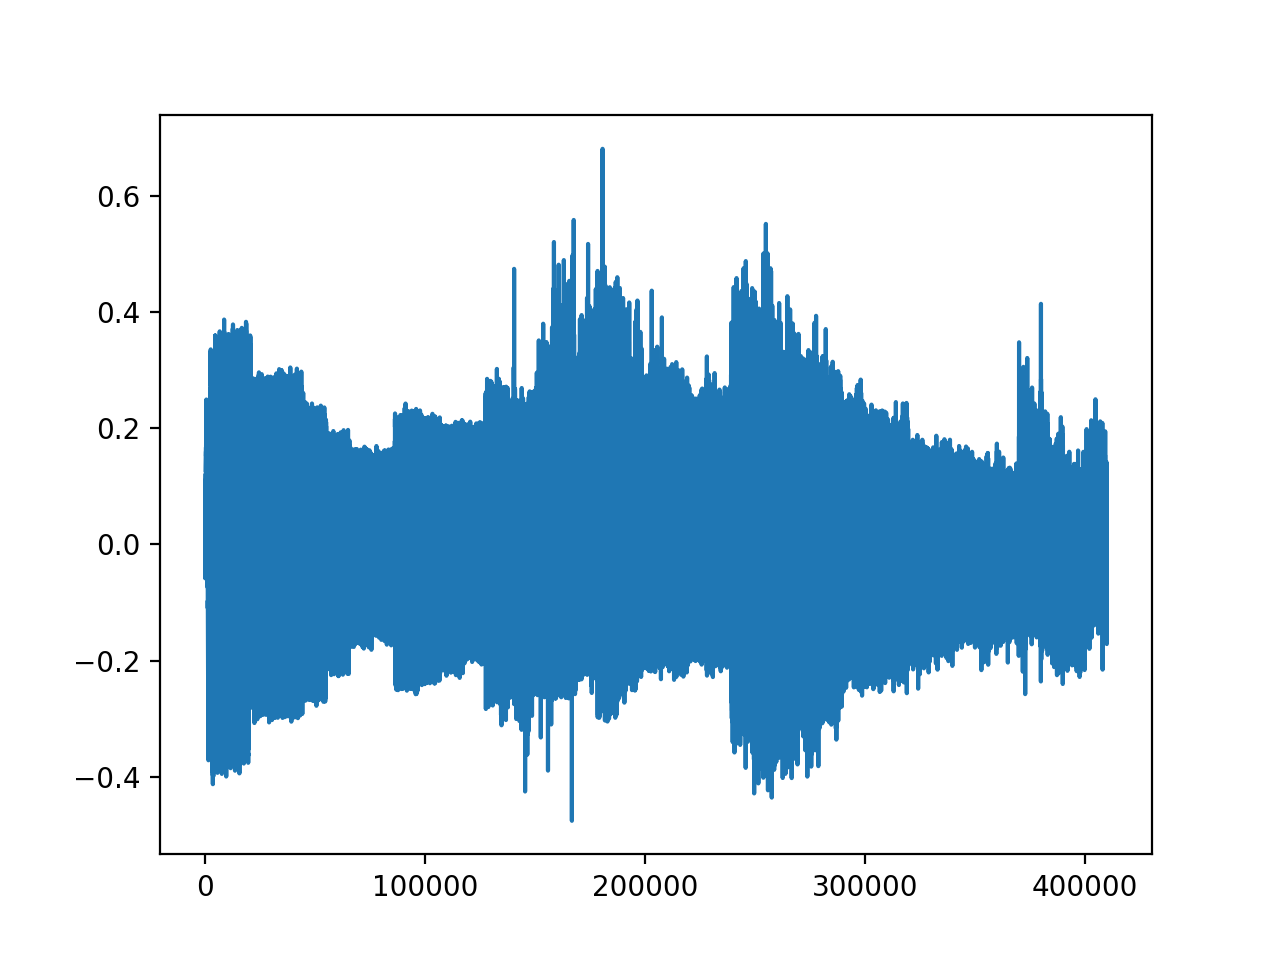

410121 0.014614820091061598


In [6]:
plt.figure()
plt.plot(w)
plt.show()
print(len(w), w[0])

In [9]:
def slice(x):
    x_slice = []
    k=0
    for t0 in data["start_times"]:
        t1 = data["end_times"][k]
        x_slice.append(np.array(x[t0:t1]))
        k += 1
    return x_slice

In [11]:
# Slice data in different trajectories with different input freq
u_slice = slice(u)
theta_slice = slice(theta)
w_slice = slice(w)
u_slice2 = slice(u)
theta_slice2 = slice(theta)
w_slice2 = slice(w)

# Our analysis of signals:
# seems like w basically only noise in low freqs? and inconsistent in high freqs?
# only keep slices with f < 20Hz i.e. k < 32, otherwise gyro crazy
# only keep f > 1Hz, otherwise basically no peak at fund freq:
# always a pretty big peak at 6Hz, which for low freqs is basically all there is? from low-level controller?
# fund freq becomes biggest peak only for idx > 6!

# Cut exp in different input freqs
#start = 7
#end = 29
#step = 2
# One long exp with all input freqs
start = 7
end = 29
step = 0

if step > 0:
    # Stack slices on top of each other with start:end:step
    u_slice = u_slice[start:end:step]
    theta_slice = theta_slice[start:end:step]
    w_slice = w_slice[start:end:step]
    #u_slice.append(np.array(u_slice2[29]))
    #theta_slice.append(np.array(theta_slice2[29]))
    #w_slice.append(np.array(w_slice2[29]))
else:
    # Or make one long experiment start:end
    t0 = data["start_times"][start]
    tf = data["start_times"][end]
    u_slice = [np.array(u[t0:tf])]
    theta_slice = [np.array(theta[t0:tf])]
    w_slice = [np.array(w[t0:tf])]

print(u_slice, u_slice2[29])
print(len(u_slice))

[array([  36.68279333,   37.50073467,   37.5703203 , ..., -110.31461757,
        -90.03497061,  -67.86175174])] [ -43.77841917  -20.99653905   -1.14034536 ... -156.61875792 -132.41781058
 -104.70183879]
1


<IPython.core.display.Javascript object>


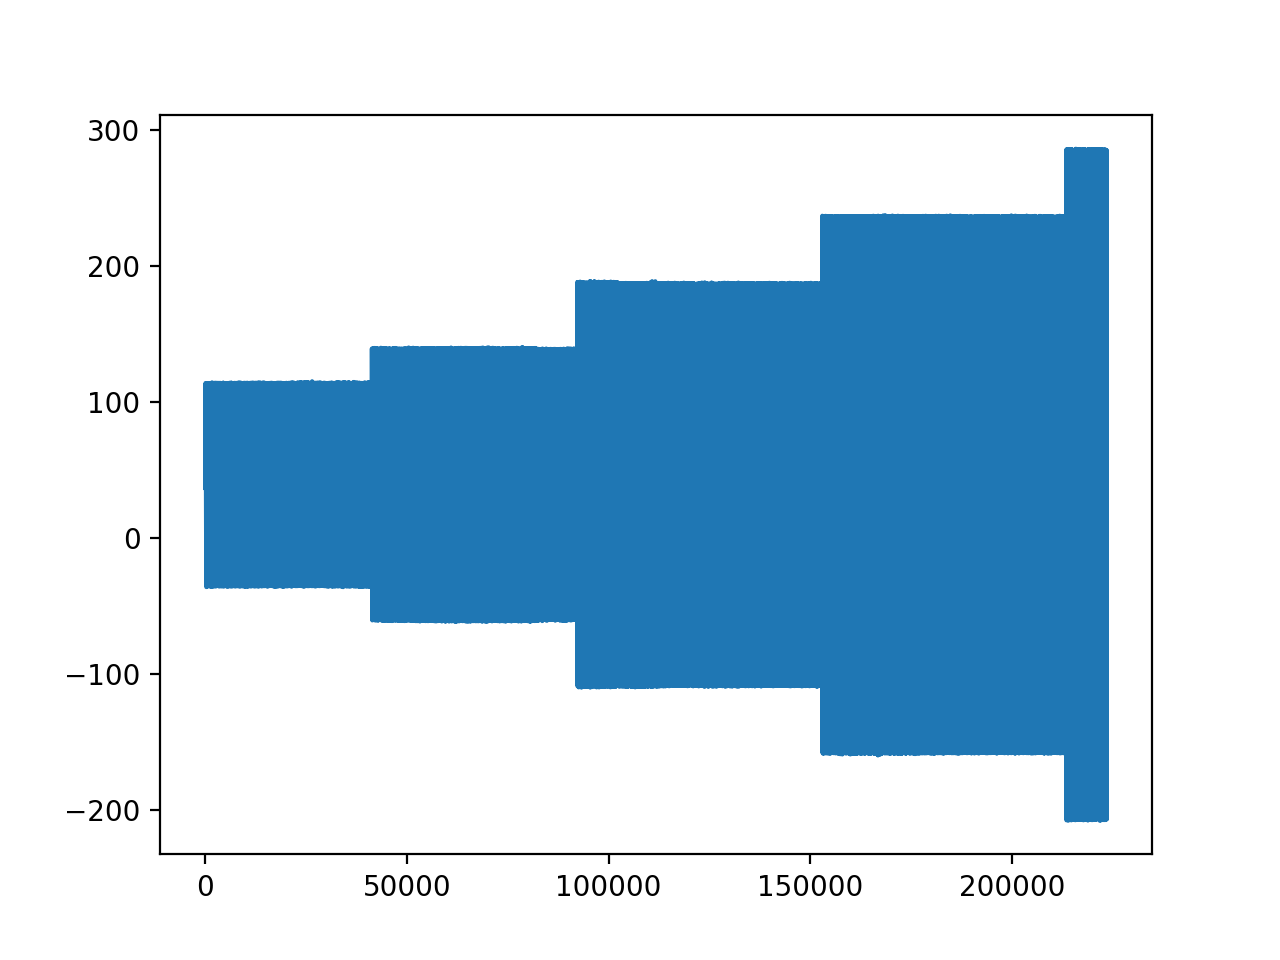

In [12]:
plt.figure()
for l in range(len(u_slice)):
    plt.plot(u_slice[l])
plt.show()

In [14]:
def myfft(x, dt, plot):
    N = len(x)
    freq = np.arange(0, N) / N / dt
    Y = np.fft.fft(x)
    if plot:
        plt.plot(freq, np.abs(Y))
    return Y

<IPython.core.display.Javascript object>


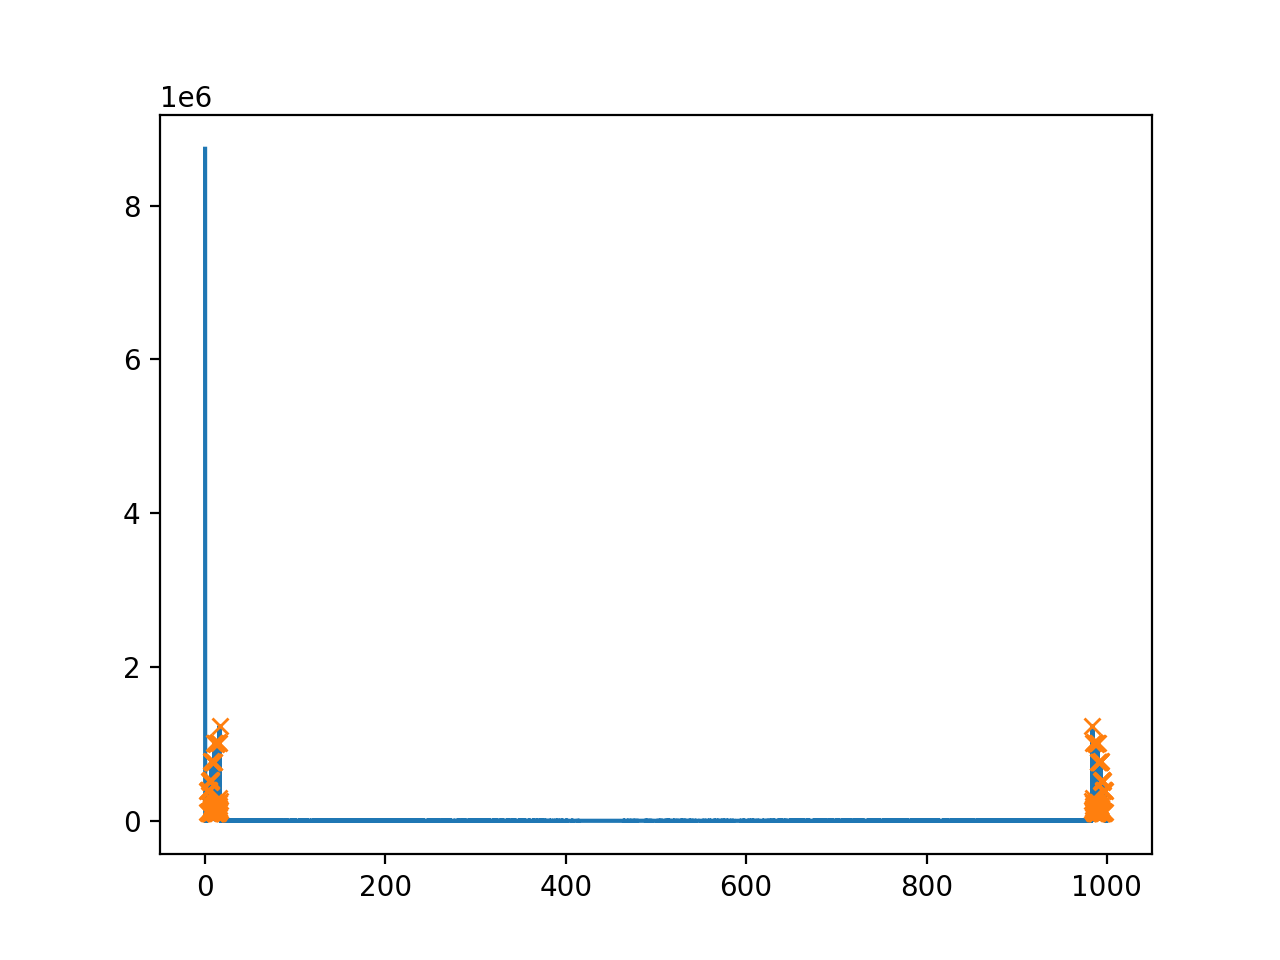

0 2.501219288472466 223491 308
More than 2 peaks detected for slice 0, threshold wrong?


In [15]:
# Compute fundamental frequency for each slice
plt.figure()
u = u_slice[0]
N = len(u)
freq = np.arange(0,N)/N/dt
U = myfft(u, dt, True)
Uabs = np.abs(U)
peaks, properties = signal.find_peaks(Uabs, height=1e5)
plt.plot(freq[peaks], Uabs[peaks], "x")
plt.show()

fund_freqs = []
for m in range(len(u_slice)):
    u = u_slice[m]
    N = len(u)
    freq = np.arange(0,N)/N/dt
    U = myfft(u, dt, False)
    Uabs = np.abs(U)
    peaks, properties = signal.find_peaks(Uabs, height=1e5)
    fund_freq = freq[peaks[0]]
    print(m, fund_freq, len(u), len(peaks))
    fund_freqs.append(fund_freq)
    if len(peaks) > 2:
        print(f'More than 2 peaks detected for slice {m}, threshold wrong?')

# Reslice all signals to keep integer number of periods in theta?
# At least show all peaks in data
plt.figure()
for k in range(len(theta_slice)):
    theta = theta_slice[k]
    N = len(theta)
    peaks, properties = signal.find_peaks(theta, prominence=1e-3)
    time = np.arange(0, len(theta) * dt, dt)
    plt.plot(time, theta)
    plt.plot(time[peaks], theta[peaks], "x")
    print(k, fund_freqs[k], properties['prominences'].min(), properties['prominences'].max())
plt.show()

In [16]:
from scipy.stats import multivariate_normal

def myfilter(x, f_cut, dt, filter='square', **kwargs):
    N =len(x)
    centered_f = np.fft.fftshift(np.fft.fftfreq(N, dt))
    X = np.fft.fft(x)
    if filter == 'square':
        square = np.abs(centered_f) < f_cut
        x_filt = np.real(np.fft.ifft(np.fft.ifftshift(np.fft.fftshift(X) * square)))
    elif filter == 'gaussian':
        var = (f_cut / 2.58) ** 2
        window = multivariate_normal.pdf(centered_f, mean=0, cov=var) * np.sqrt(2 * np.pi * var)
        x_filt = np.real(np.fft.ifft(np.fft.ifftshift(np.fft.fftshift(X) * window)))
    elif filter == 'cheby1':
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby1.html
        order = kwargs['order']
        max_ripple = kwargs['max_ripple']
        sos = signal.cheby1(order, max_ripple, f_cut, 'lowpass', output='sos', fs=2*np.pi/dt)
        x_filt = signal.sosfilt(sos, x)
    elif filter == 'cheby2':
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheby2.html
        order = kwargs['order']
        max_ripple = kwargs['max_ripple']
        sos = signal.cheby2(order, max_ripple, f_cut, 'lowpass', output='sos', fs=2*np.pi/dt)
        x_filt = signal.sosfilt(sos, x)
    elif filter == 'butter':
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
        order = kwargs['order']
        sos = signal.butter(order, f_cut, 'lowpass', output='sos', fs=2*np.pi/dt)
        x_filt = signal.sosfilt(sos, x)
    elif filter == 'none':
        x_filt = x
    else:
        raise NotImplementedError('Unknown filter.')
    return x_filt

In [17]:
# Interpolate t_x = (t, x) at new times t
from scipy.interpolate import interp1d
def interpolate(t, t_x, method='linear'):
    points, values = t_x[:, 0], t_x[:, 1:]
    interp_list = [interp1d(x=points, y=values[:, i], kind=method) for i
                   in range(values.shape[1])]
    def interp(x):
        return np.array([f(x) for f in interp_list]).T
    interpolate_x = interp(t)
    return interpolate_x.reshape(1, -1)

# Sumbsample signal t_x at times t_eval
def subsample(t_eval, t_x, subsampling='interpolate', D=30):
    if subsampling == 'interpolate':
        subsampled_x = interpolate(t_eval, t_x)
    elif subsampling == 'oneinD':
        subsampled_x = t_x[::D, 1:]
    else:
        raise Exception('No such subsampling strategy has been defined.')
    return subsampled_x.reshape(-1, 1)

In [19]:
# Parameters for filtering
f_cut = 50
filter_type = 'gaussian'
kwargs = {'order': 2, 'max_ripple': 1}
theta_filt = [myfilter(x, f_cut, dt, filter_type, **kwargs) for x in theta_slice]
w_filt = [myfilter(x, f_cut, dt, filter_type, **kwargs) for x in w_slice]
# Filtering u(t) is slightly different (due to Gaussian filter lowering the amplitude of sinusoidal u(t) over time)
#u_filt = [myfilter(x, f_cut, dt, filter_type, **kwargs) for x in u_slice]
#u_filt = u_slice
u_filt = [myfilter(x, 4*f_cut, dt, 'butter', **{'order': 2}) for x in u_slice]

<IPython.core.display.Javascript object>


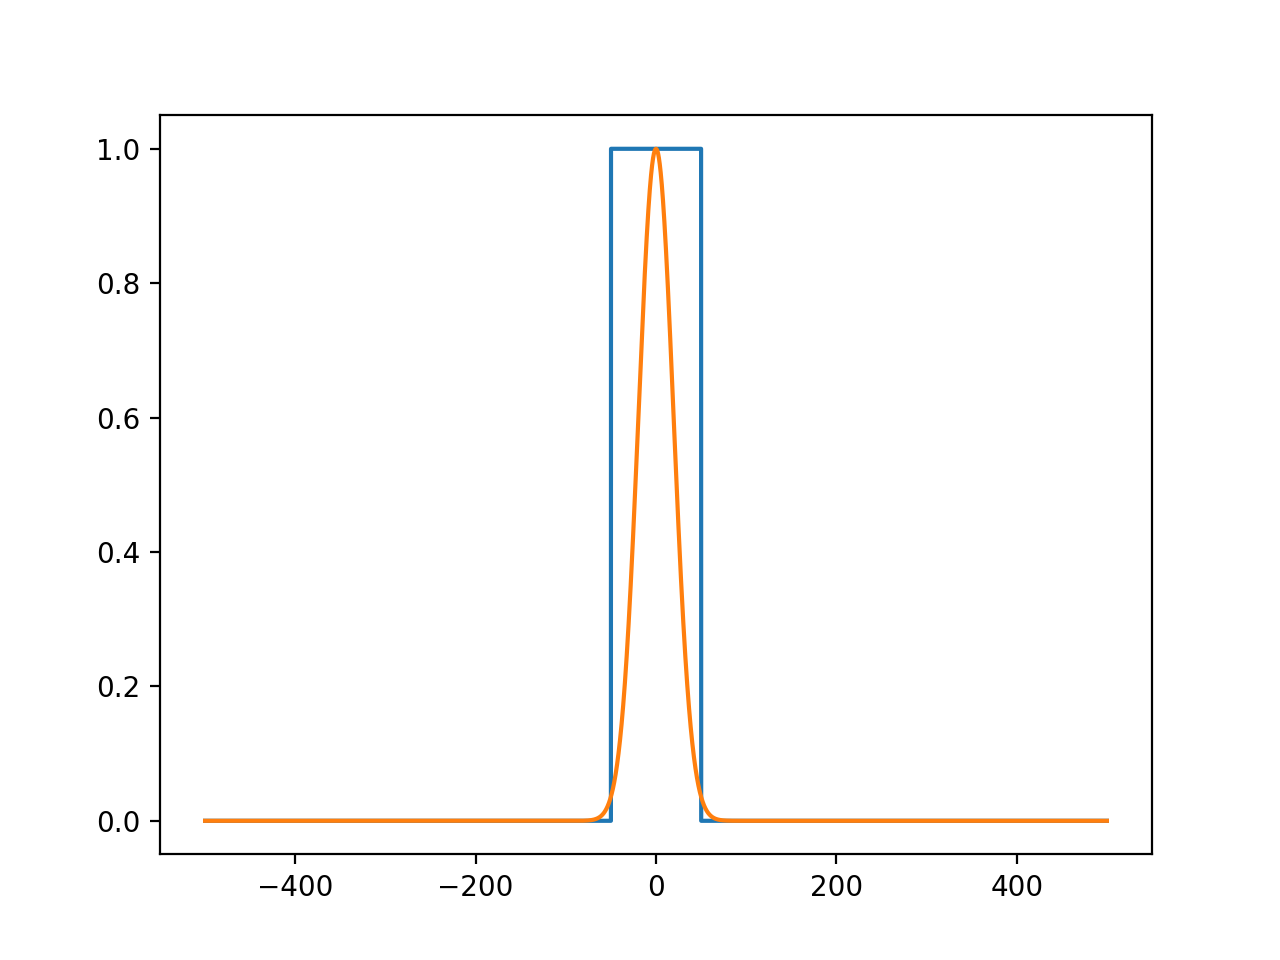

<IPython.core.display.Javascript object>


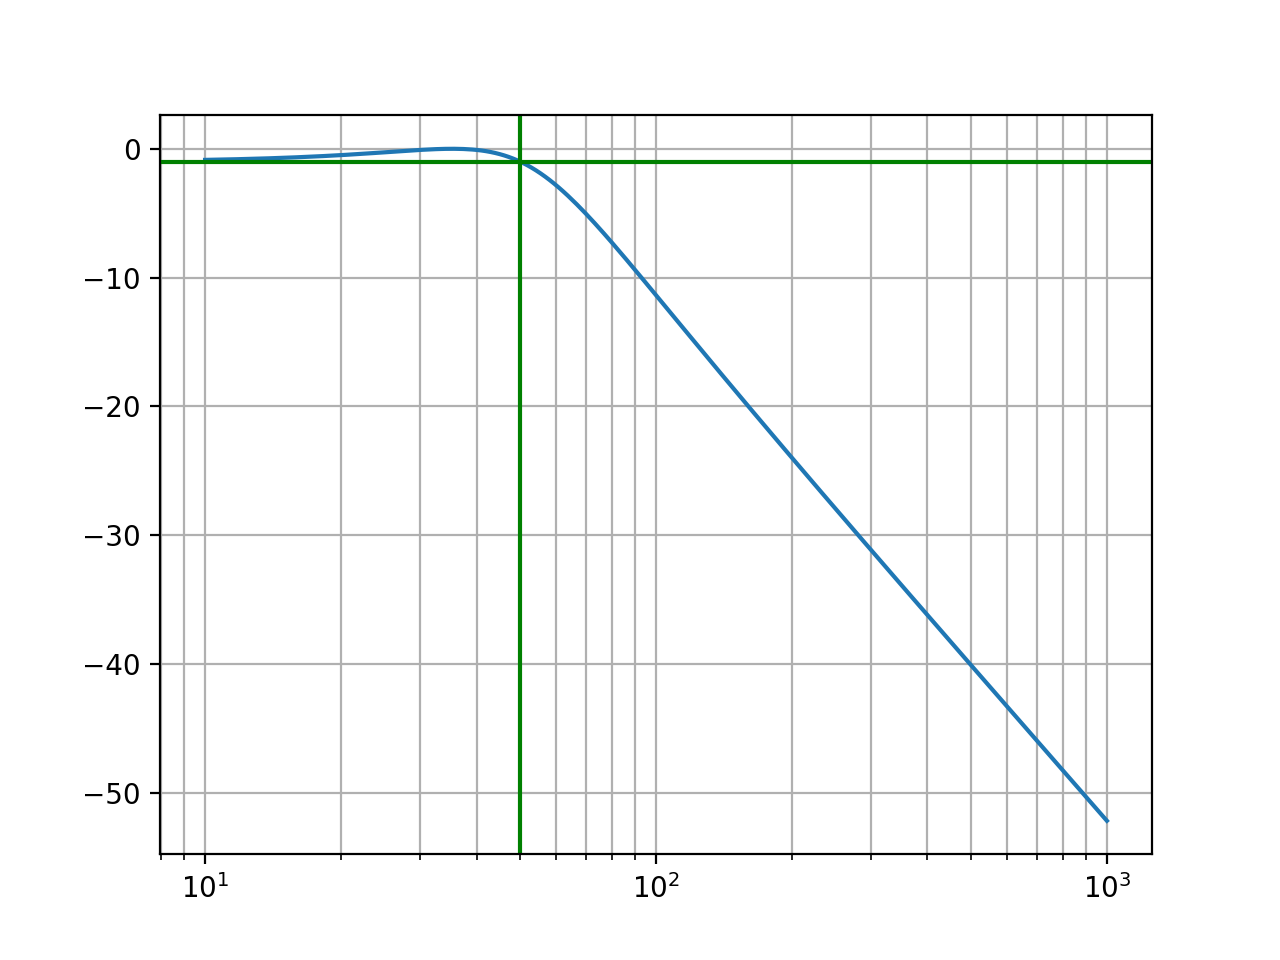

<IPython.core.display.Javascript object>


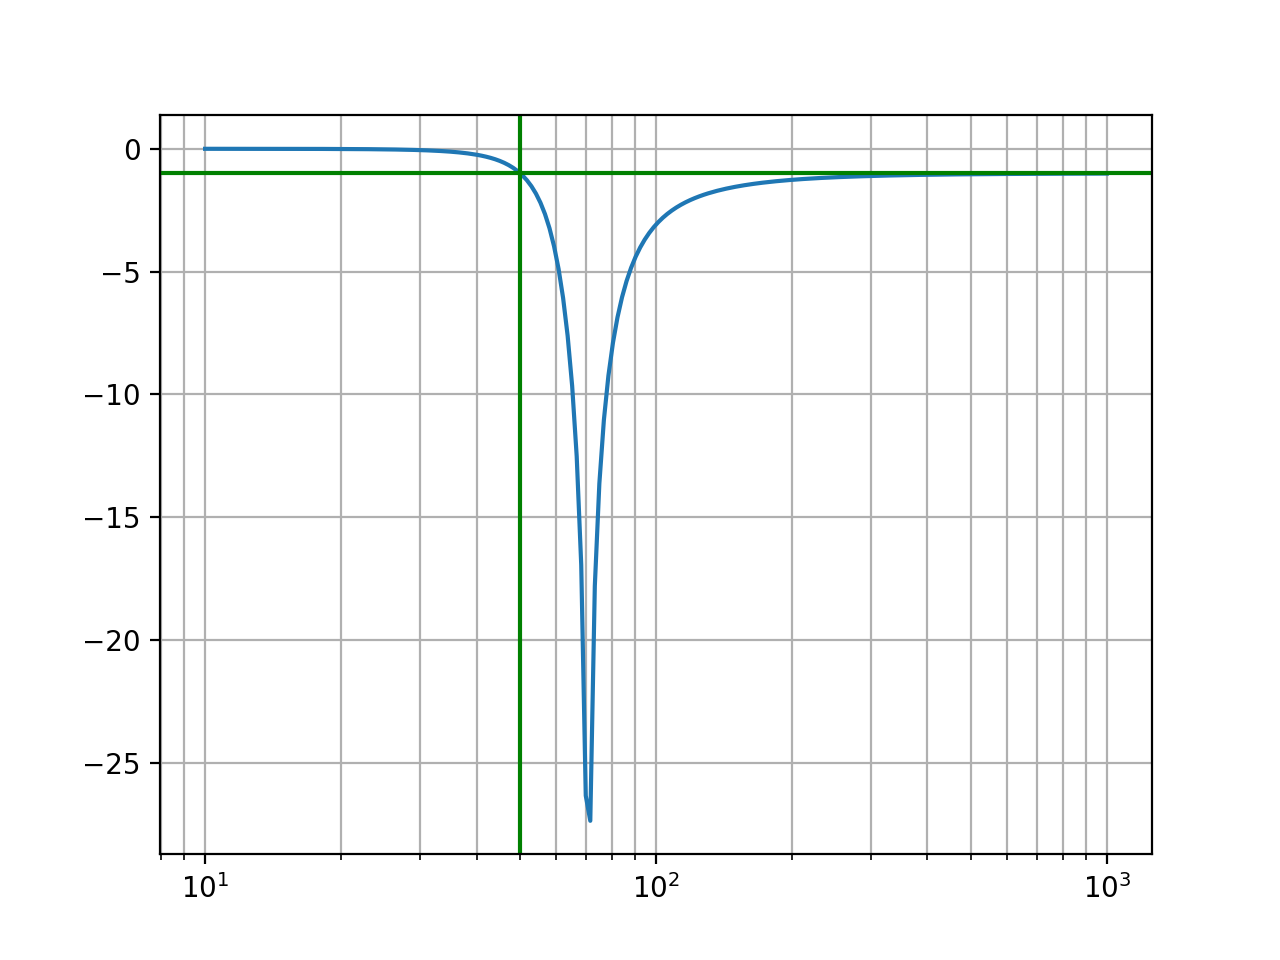

In [20]:
# Visualize filters
N =len(w_slice[-1])
centered_f = np.fft.fftshift(np.fft.fftfreq(N,dt))
# Square
square = np.abs(centered_f) < f_cut
plt.figure()
plt.plot(centered_f, square)
# Gaussian
var = (f_cut / 2.58) ** 2
window = multivariate_normal.pdf(centered_f, mean=0, cov=var) * np.sqrt(2 * np.pi * var)
plt.plot(centered_f, window)
plt.show()
# Cheby1
plt.figure()
order = kwargs['order']
max_ripple = kwargs['max_ripple']
b, a = signal.cheby1(order, max_ripple, f_cut, 'lowpass', output='ba', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.grid(which='both', axis='both')
plt.axvline(f_cut, color='green')
plt.axhline(-max_ripple, color='green')
plt.show()
# Cheby2
plt.figure()
order = kwargs['order']
max_ripple = kwargs['max_ripple']
b, a = signal.cheby2(order, max_ripple, f_cut, 'lowpass', output='ba', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.grid(which='both', axis='both')
plt.axvline(f_cut, color='green')
plt.axhline(-max_ripple, color='green')
plt.show()

<IPython.core.display.Javascript object>


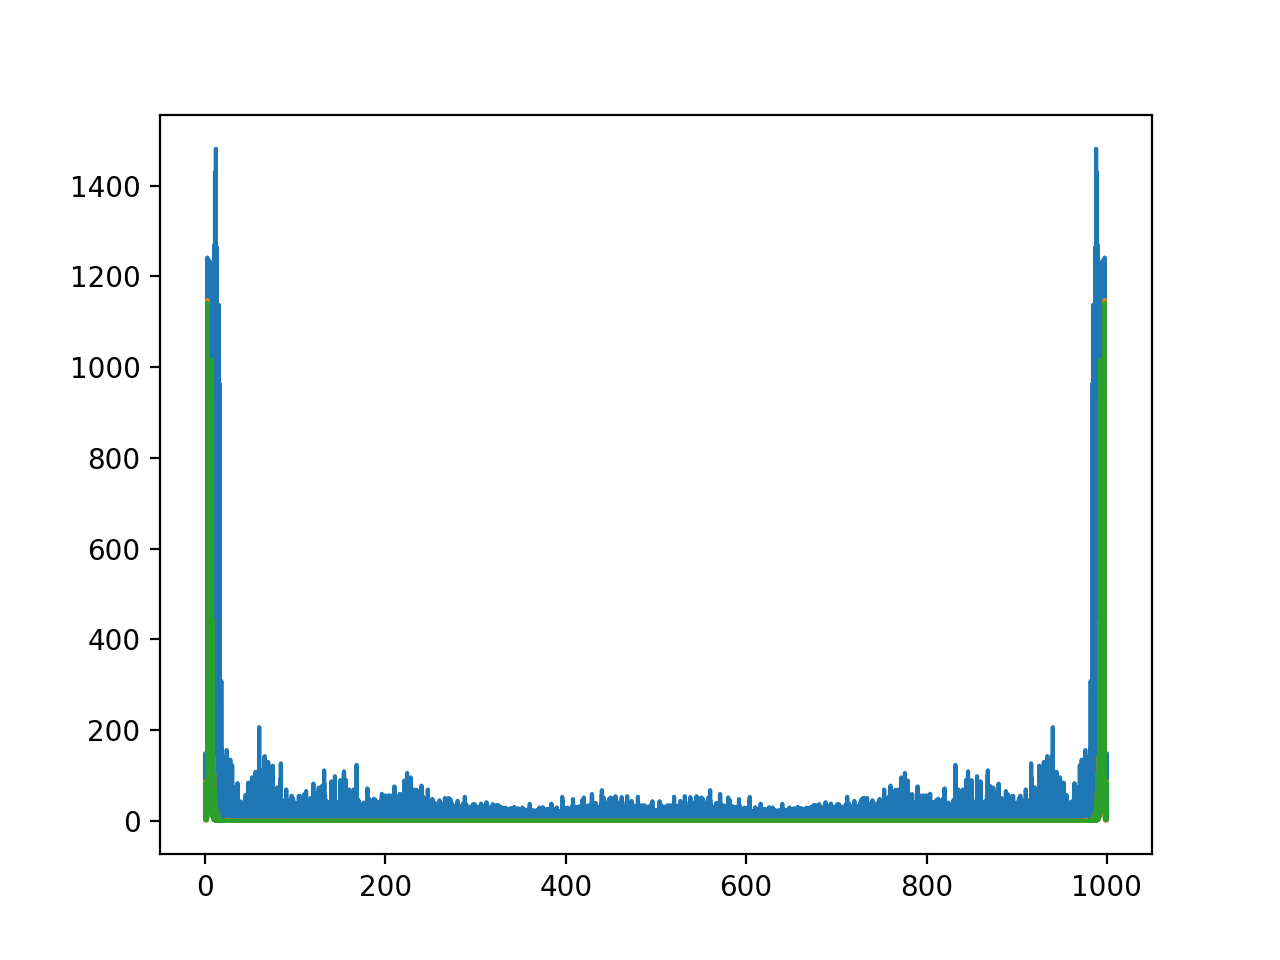

<IPython.core.display.Javascript object>


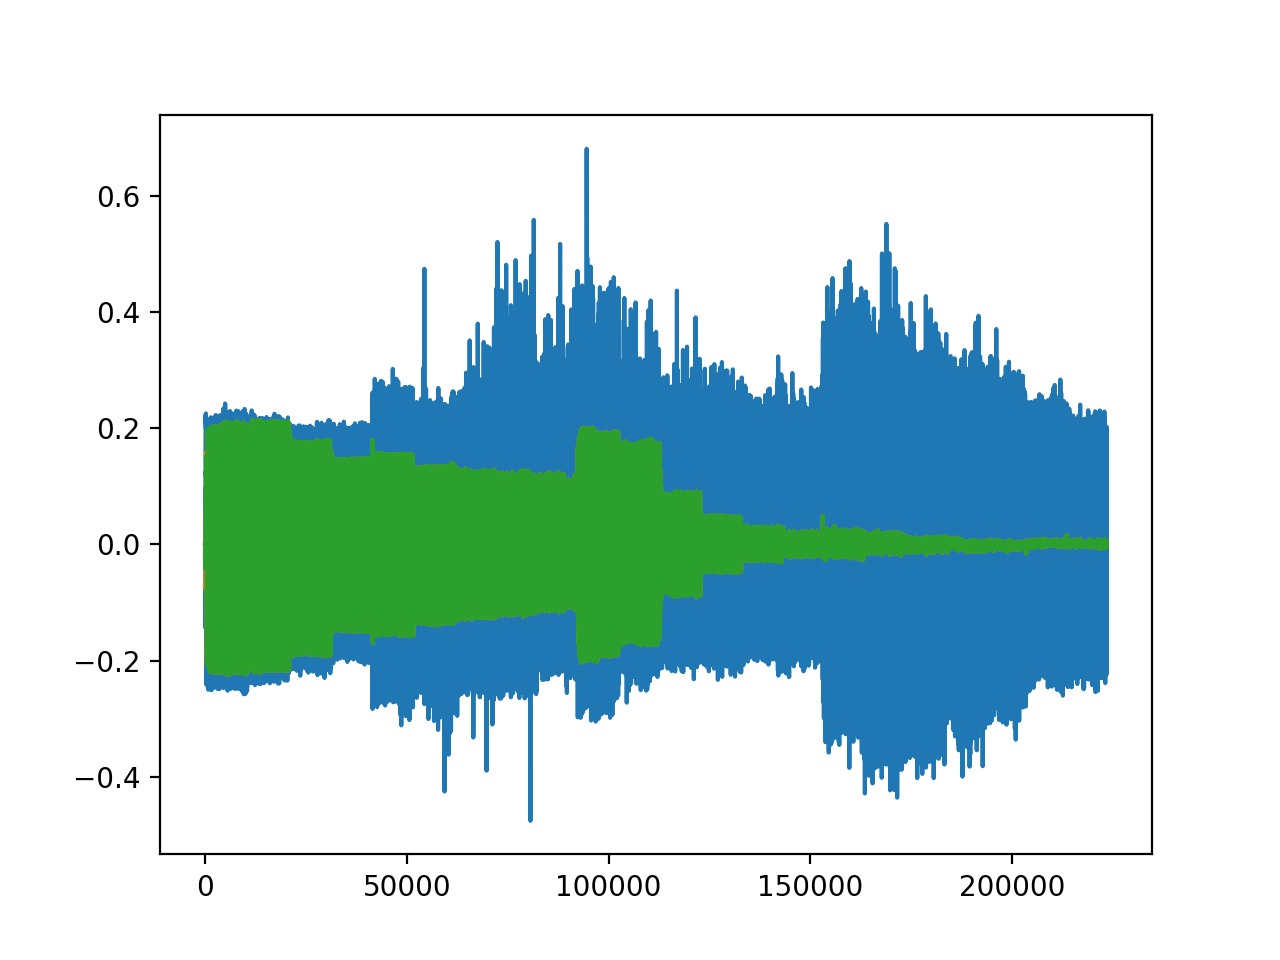

In [21]:
# Test analogous vs digital Chebyshev
y = w_slice[0]
order = 4
max_ripple = 5
b, a = signal.cheby1(order, max_ripple, f_cut, 'lowpass', output='ba', analog=True)
bz, az = signal.bilinear(b, a, 1/dt)
#y_chebya = signal.filtfilt(bz, az, y)
zi = signal.lfilter_zi(bz, az)
y_chebya, _ = signal.lfilter(bz, az, y, zi=zi*y[0])
y_chebyd = myfilter(y, f_cut, dt, 'cheby1', **{'order': order, 'max_ripple': max_ripple})

# FFT
plt.figure()
Y = myfft(y, dt, True)
Y_chebya = myfft(y_chebya, dt, True)
Y_chebyd = myfft(y_chebyd, dt, True)
plt.show()

# Filtered signal
plt.figure()
plt.plot(y)
plt.plot(y_chebya)
plt.plot(y_chebyd)
plt.show()

<IPython.core.display.Javascript object>


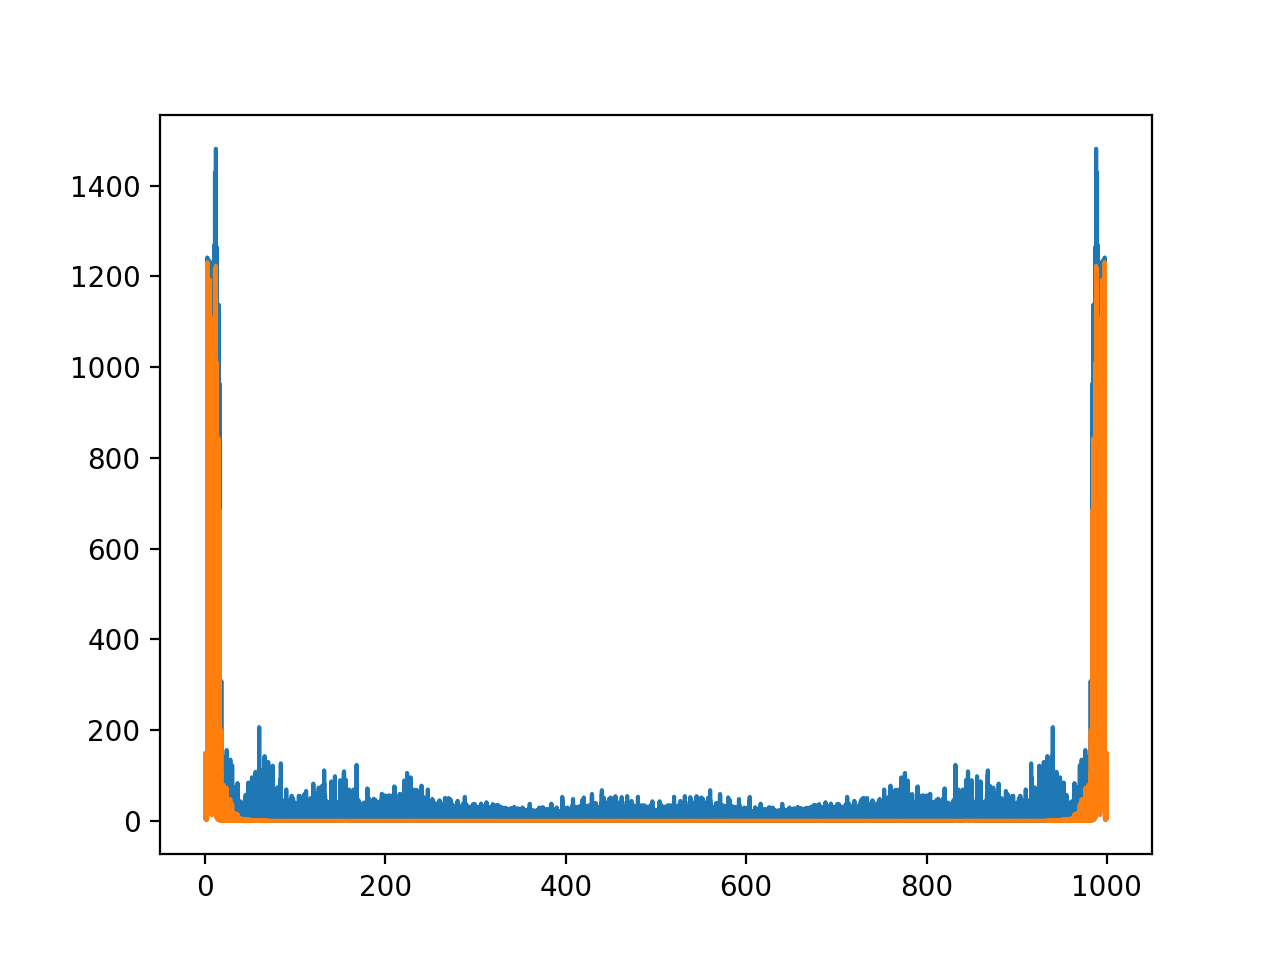

<IPython.core.display.Javascript object>


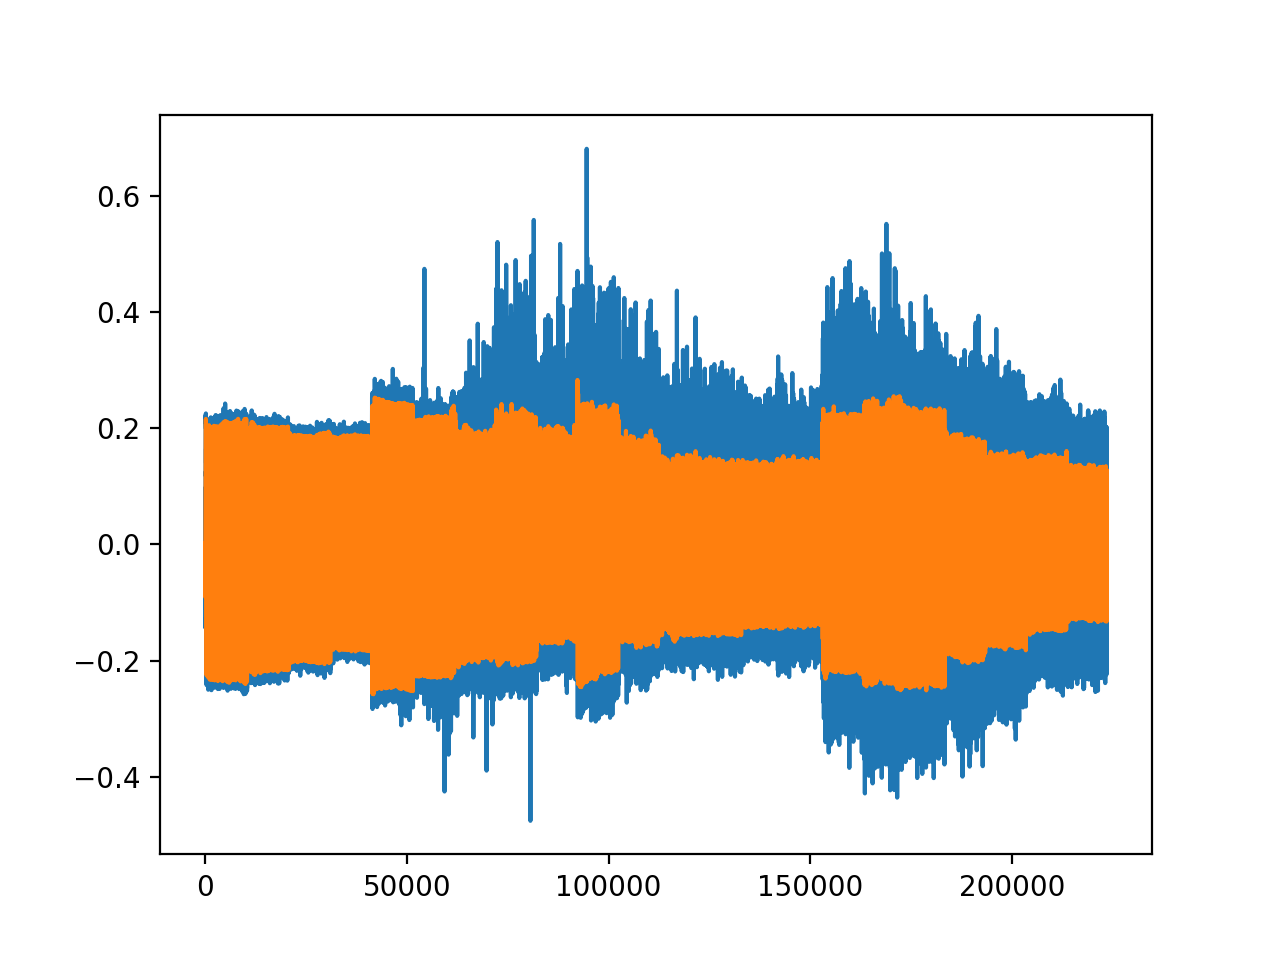

In [22]:
# Result of myfilter
# FFT
plt.figure()
y = w_slice[0]
y_filt = myfilter(y, f_cut, dt, filter_type, **kwargs)
Y = myfft(y, dt, True)
Y_filt = myfft(y_filt, dt, True)
plt.show()

# Filtered signal
plt.figure()
plt.plot(y)
plt.plot(y_filt)
plt.show()

In [25]:
# Slice beginning and end of trajs to avoid artifacts from filtering
u_slice = [u_slice[k][100:-100] for k in range(len(u_slice))]
theta_slice = [theta_slice[k][100:-100] for k in range(len(u_slice))]
w_slice = [w_slice[k][100:-100] for k in range(len(u_slice))]
u_filt = [u_filt[k][100:-100] for k in range(len(u_slice))]
theta_filt = [theta_filt[k][100:-100] for k in range(len(u_slice))]
w_filt = [w_filt[k][100:-100] for k in range(len(u_slice))]

<IPython.core.display.Javascript object>


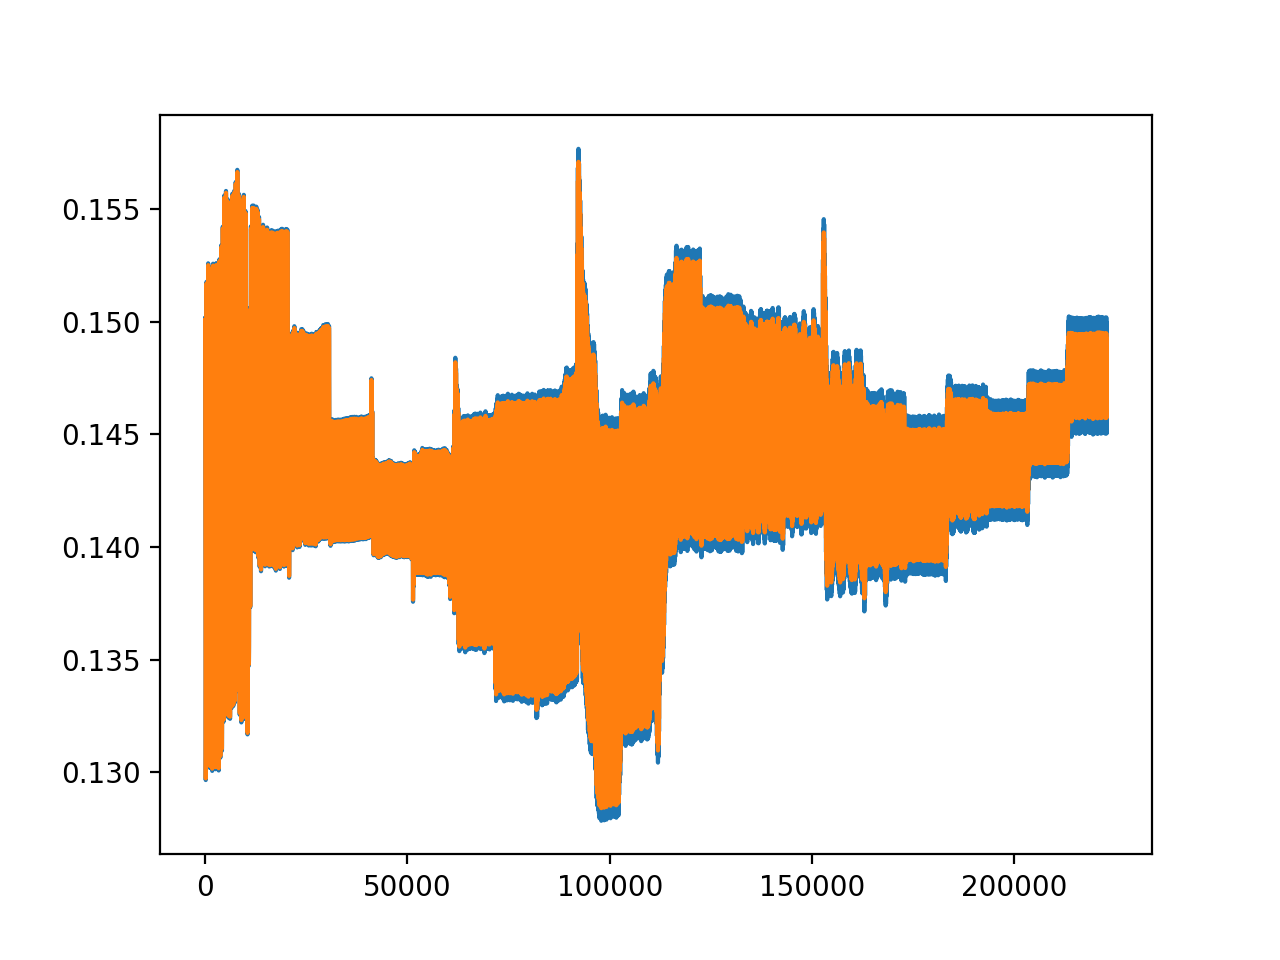

<IPython.core.display.Javascript object>


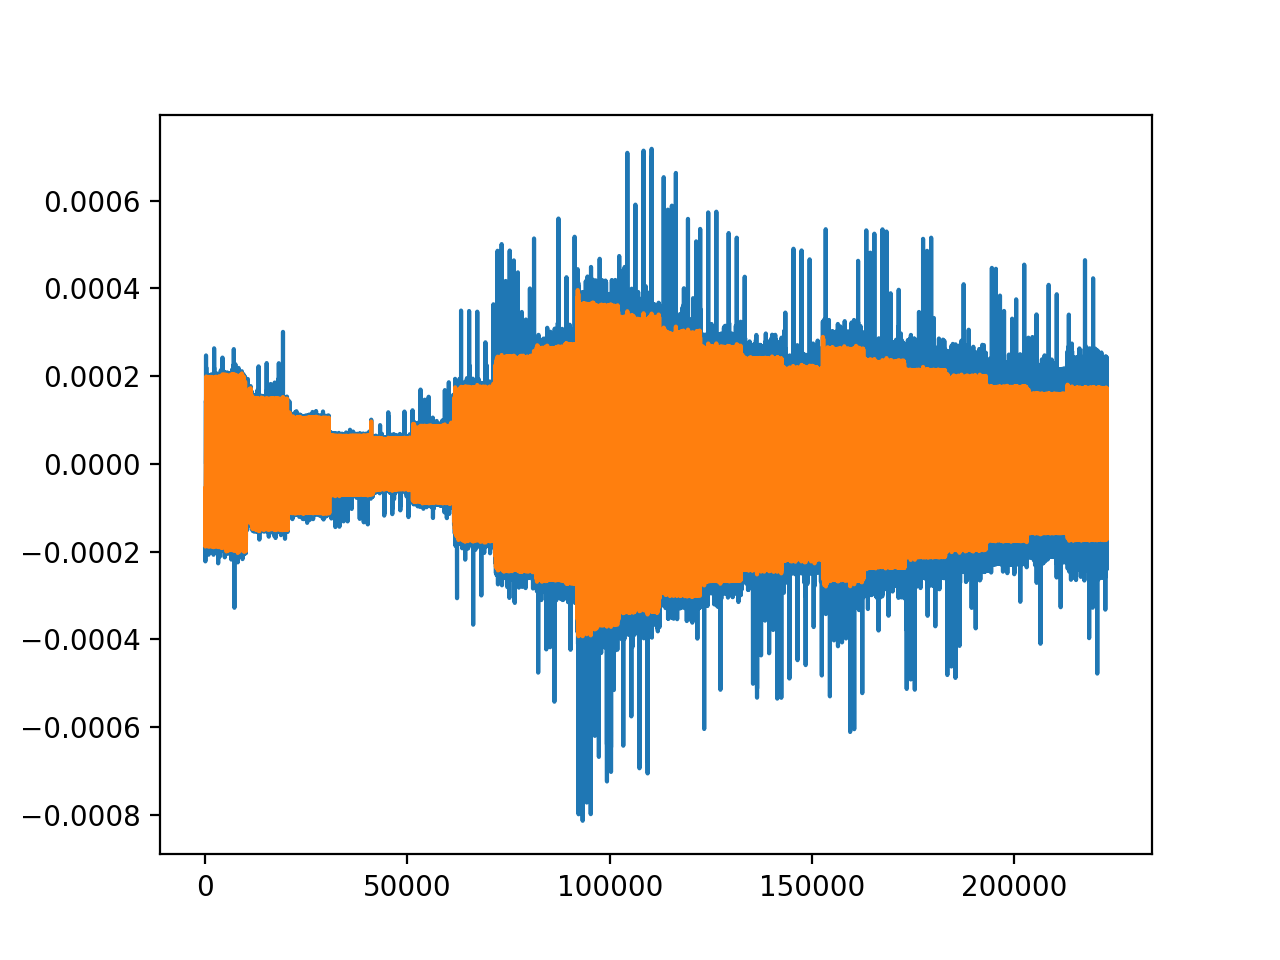

<IPython.core.display.Javascript object>


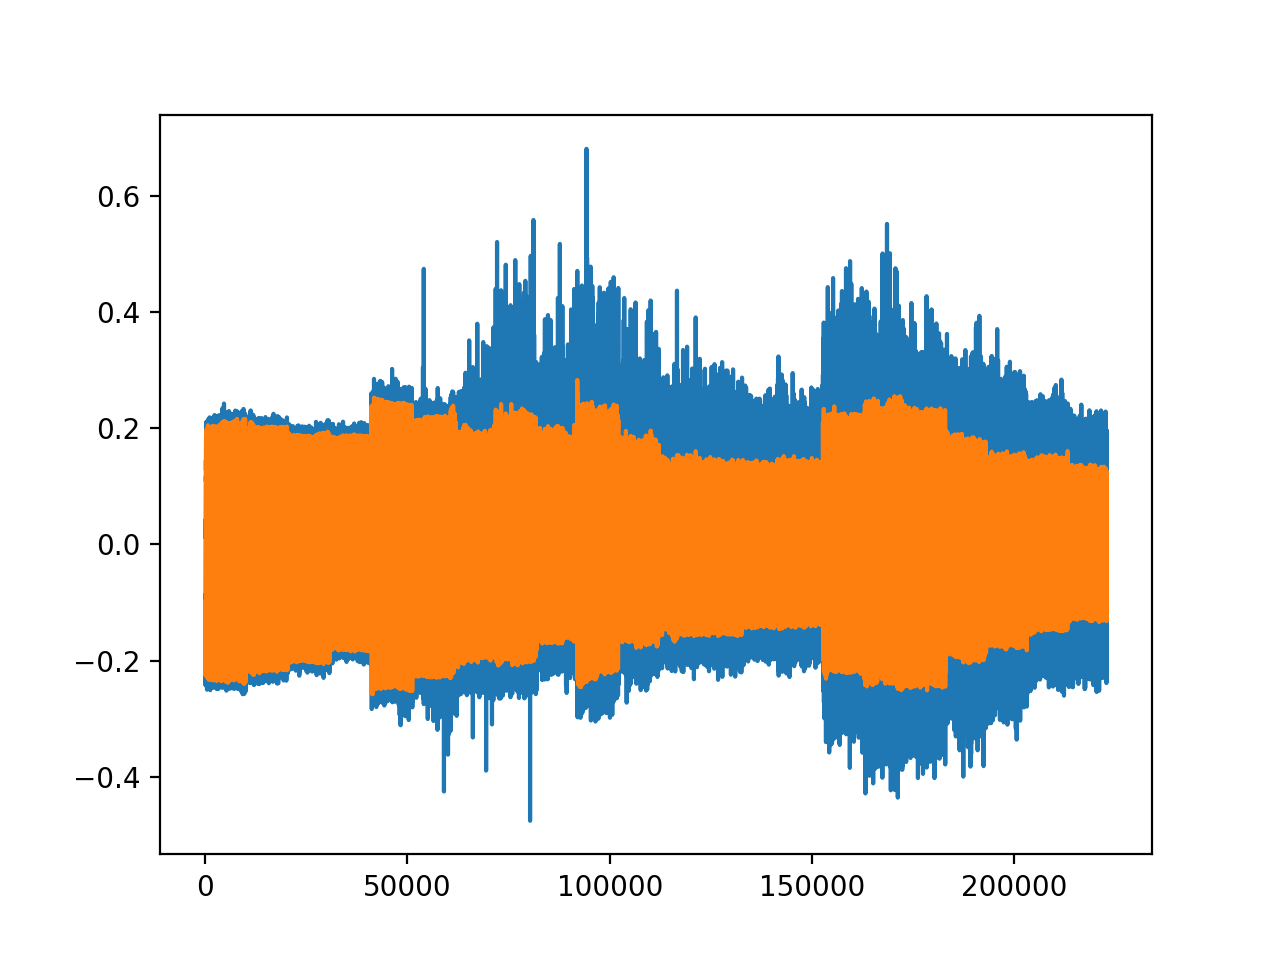

In [26]:
k = 0

plt.figure()
plt.plot(theta_slice[k])
plt.plot(theta_filt[k])
plt.show()

plt.figure()
plt.plot(np.diff(theta_slice[k]))
plt.plot(np.diff(theta_filt[k]))
plt.show()

plt.figure()
plt.plot(w_slice[k])
plt.plot(w_filt[k])
plt.show()

In [17]:
# Save full slice data before subsampling
import os
import pandas as pd
df_u = pd.DataFrame(np.array(u_filt))
df_theta = pd.DataFrame(np.array(theta_filt))
df_w = pd.DataFrame(np.array(w_filt))
save = False
folder = f'../../Data/Wandercraft_id/'
if save:
    os.makedirs(folder, exist_ok=True)
    df_u.to_pickle(folder + f'/u_{filter_type}{f_cut}_slice.pkl')
    df_theta.to_pickle(folder + f'/theta_{filter_type}{f_cut}_slice.pkl')
    df_w.to_pickle(folder + f'/w_{filter_type}{f_cut}_slice.pkl')
print(df_w.shape)
print(np.array(df_w.iloc[0].values))

(11, 1)
[array([ 0.10094712,  0.10271226,  0.10454204, ..., -0.0766878 ,
        -0.08006932, -0.0834164 ])                              ]


<ipython-input-17-74f2205b2b9e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_u = pd.DataFrame(np.array(u_filt))
<ipython-input-17-74f2205b2b9e>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_theta = pd.DataFrame(np.array(theta_filt))
<ipython-input-17-74f2205b2b9e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_w = 

In [27]:
# Subsample trajectories
# Here fmax = f_cut, so need fsub > 2fmax to avoid aliasing!
sub_dt = 1e-3
print(f'fsub = {1 / sub_dt} > 2 fmax = {2 * f_cut} necessary to avoid aliasing!')
D = int(sub_dt // dt)
u_filt_sub = []
theta_filt_sub = []
w_filt_sub = []
for k in range(len(u_slice)):
    time = np.arange(0, len(u_filt[k]) * dt, dt)
    sub_time = np.arange(0, len(u_filt[k]) * dt, sub_dt)
    sub_u = subsample(sub_time, 
                      t_x=np.concatenate((time.reshape(-1, 1), u_filt[k].reshape(-1, 1)), axis=1), 
                      subsampling='oneinD', D=D)
    sub_theta = subsample(sub_time, 
                          t_x=np.concatenate((time.reshape(-1, 1), theta_filt[k].reshape(-1, 1)), axis=1), 
                          subsampling='oneinD', D=D)
    sub_w = subsample(sub_time, 
                      t_x=np.concatenate((time.reshape(-1, 1), w_filt[k].reshape(-1, 1)), axis=1), 
                      subsampling='oneinD', D=D)
    u_filt_sub.append(sub_u)
    theta_filt_sub.append(sub_theta)
    w_filt_sub.append(sub_w)

fsub = 1000.0 > 2 fmax = 100 necessary to avoid aliasing!


1 222891 222891 222891


<IPython.core.display.Javascript object>


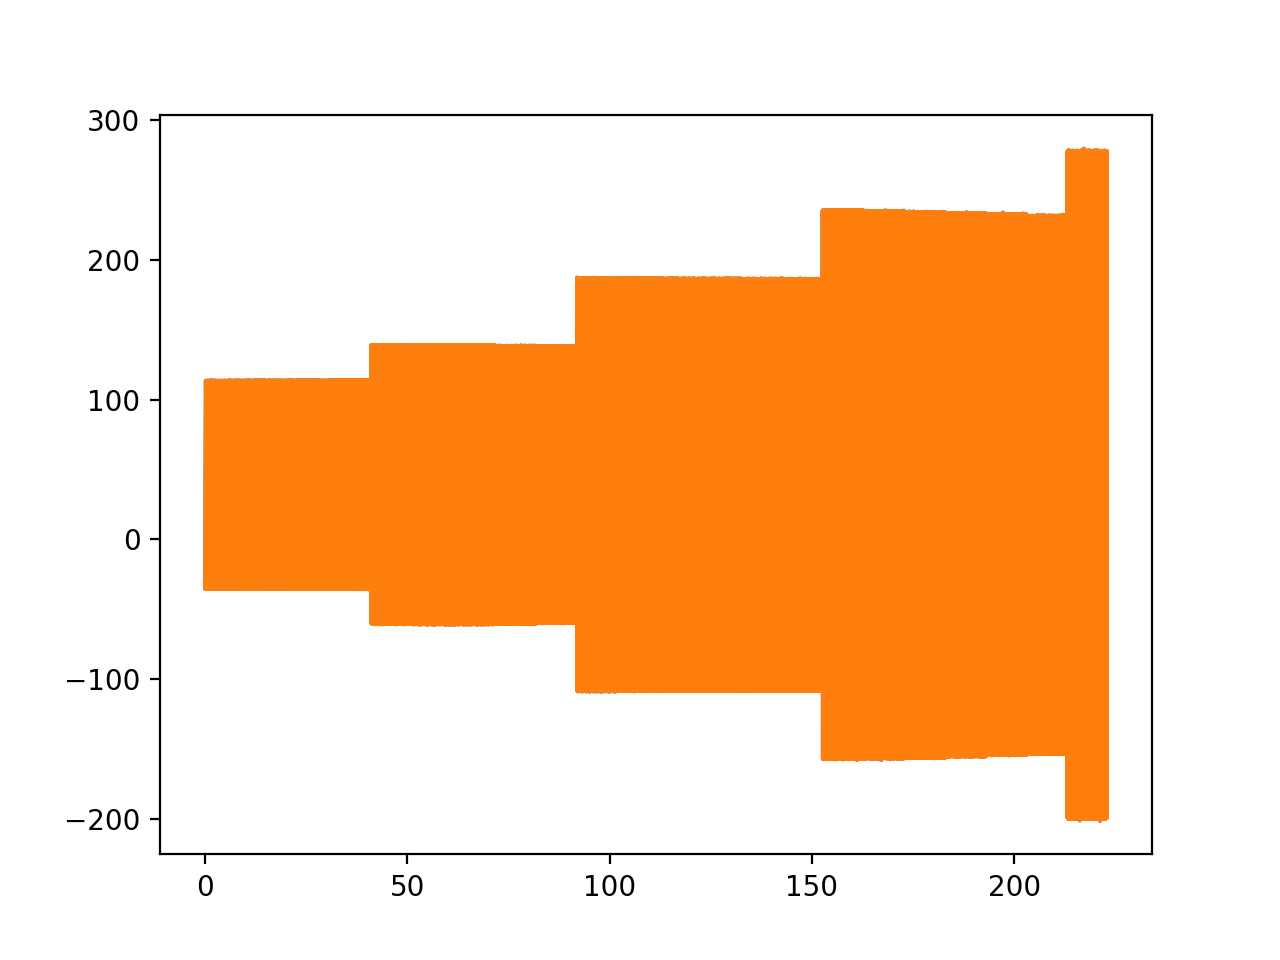

<IPython.core.display.Javascript object>


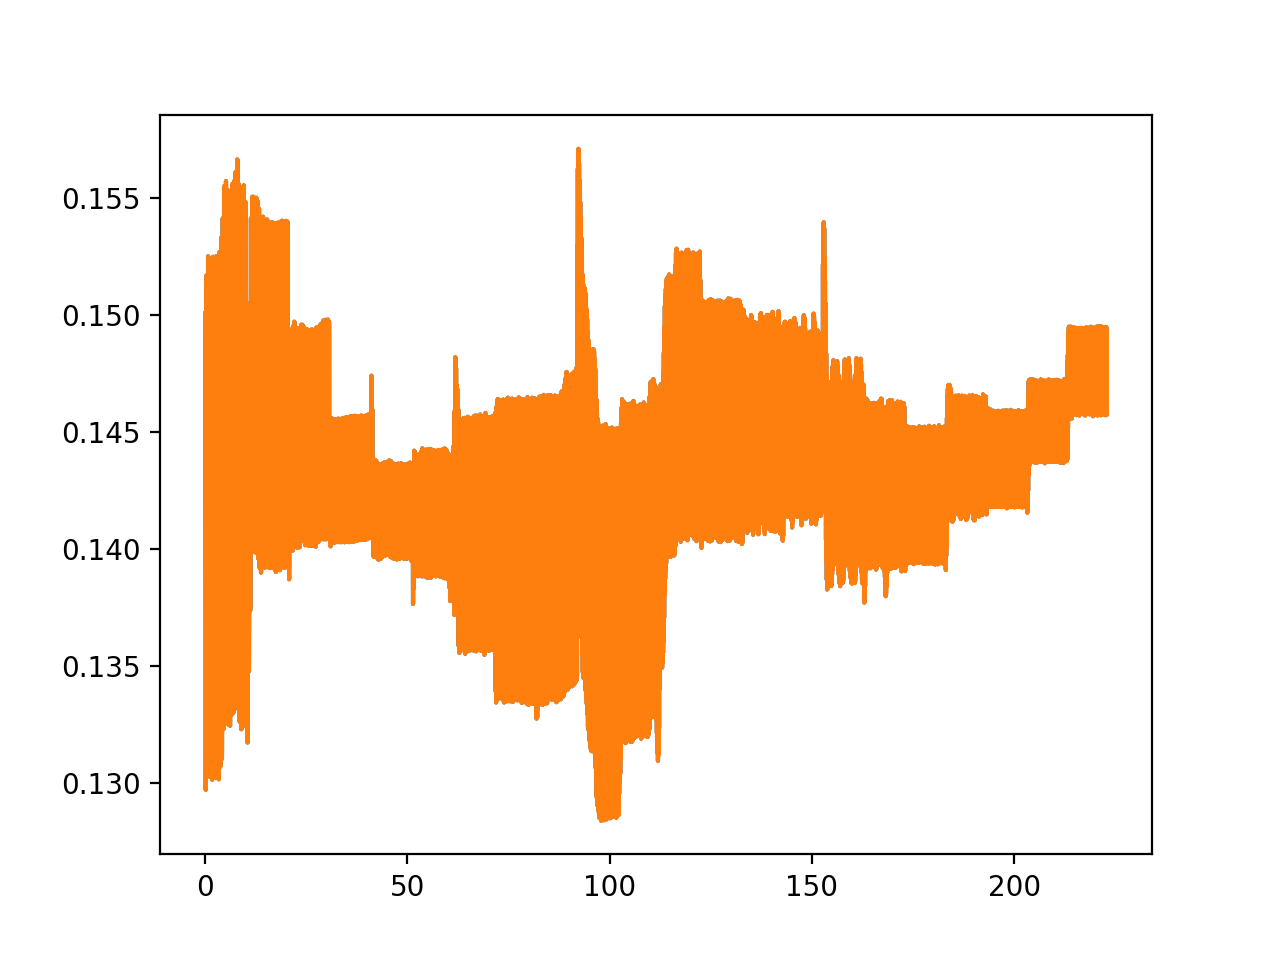

<IPython.core.display.Javascript object>


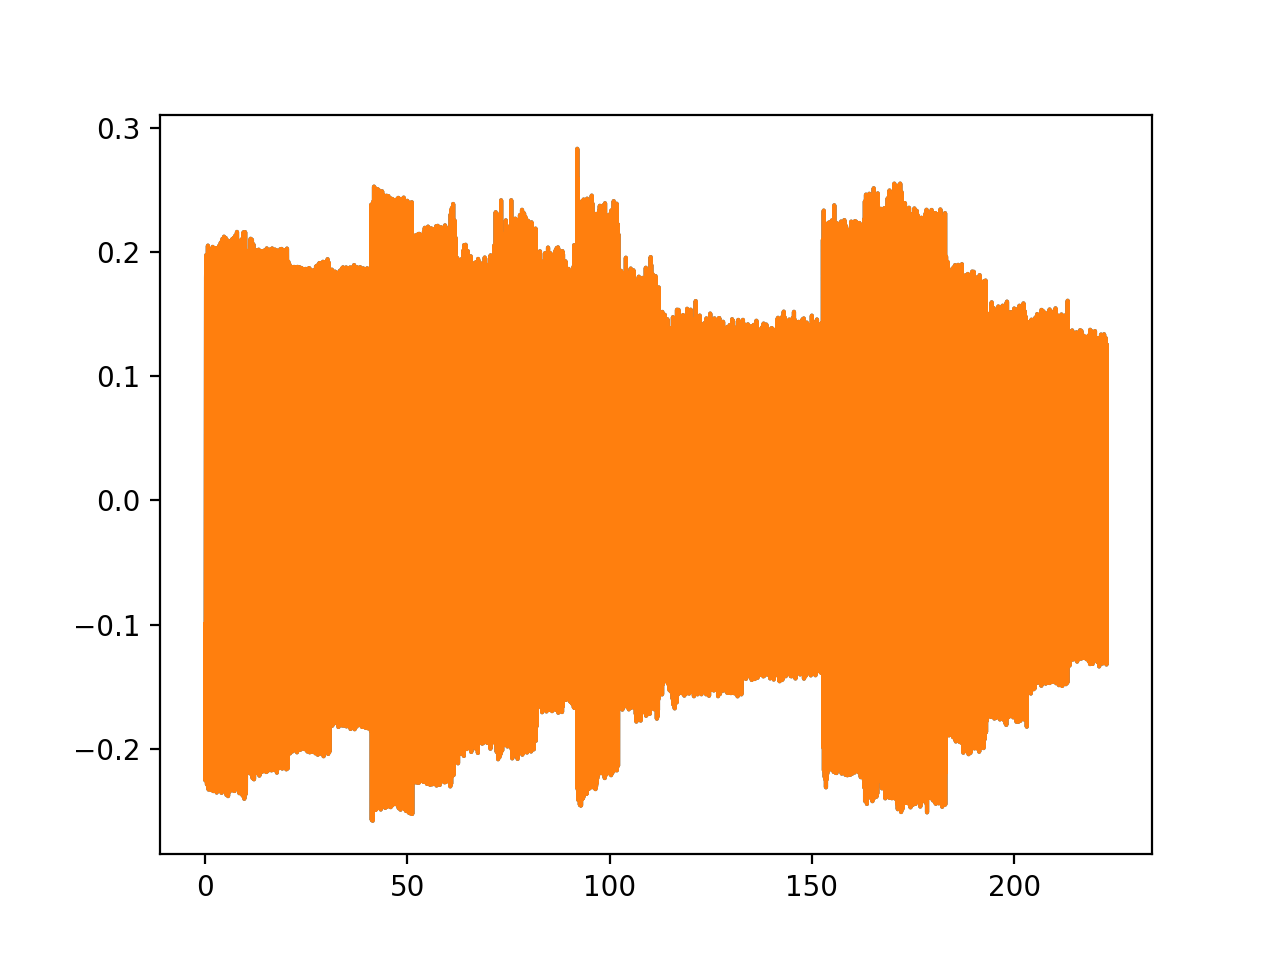

In [28]:
# Visualize data after subsampling
print(D, len(time), len(u_slice[-1]), len(sub_time))
k = 0
i = 0
j = 1000000000
i_sub = int(i / D)
j_sub = int(j / D)
time = np.arange(0, len(u_filt[k]) * dt, dt)[i:j]
sub_time = np.arange(0, len(u_filt[k]) * dt, sub_dt)[i_sub:j_sub]
plt.figure()
plt.plot(time, u_filt[k][i:j])
plt.plot(sub_time, u_filt_sub[k][i_sub:j_sub])
plt.show()
plt.figure()
plt.plot(time, theta_filt[k][i:j])
plt.plot(sub_time, theta_filt_sub[k][i_sub:j_sub])
plt.show()
plt.figure()
plt.plot(time, w_filt[k][i:j])
plt.plot(sub_time, w_filt_sub[k][i_sub:j_sub])
plt.show()

In [31]:
# Slice trajectories to all be short and have same length and sampling times for parallel simulations
N = len(u_filt_sub[0])#200#len(u_filt_sub[0])  # chosen nb of samples in each difftraj
u_train = np.zeros((0, N))
theta_train = np.zeros((0, N))
w_train = np.zeros((0, N))
for k in range(len(u_filt_sub)):
    nb_difftraj = int(len(u_filt_sub[k]) // N)
    for i in range(nb_difftraj):
        u_train = np.concatenate((u_train, u_filt_sub[k][i * N: (i+1) * N].reshape(1, -1)))
        theta_train = np.concatenate((theta_train, theta_filt_sub[k][i * N: (i+1) * N].reshape(1, -1)))
        w_train = np.concatenate((w_train, w_filt_sub[k][i * N: (i+1) * N].reshape(1, -1)))
print(u_train.shape, w_train.shape, theta_train.shape)
nb_difftraj = len(u_train)

(1, 222891) (1, 222891) (1, 222891)


0.0 0.001 0.001


<IPython.core.display.Javascript object>


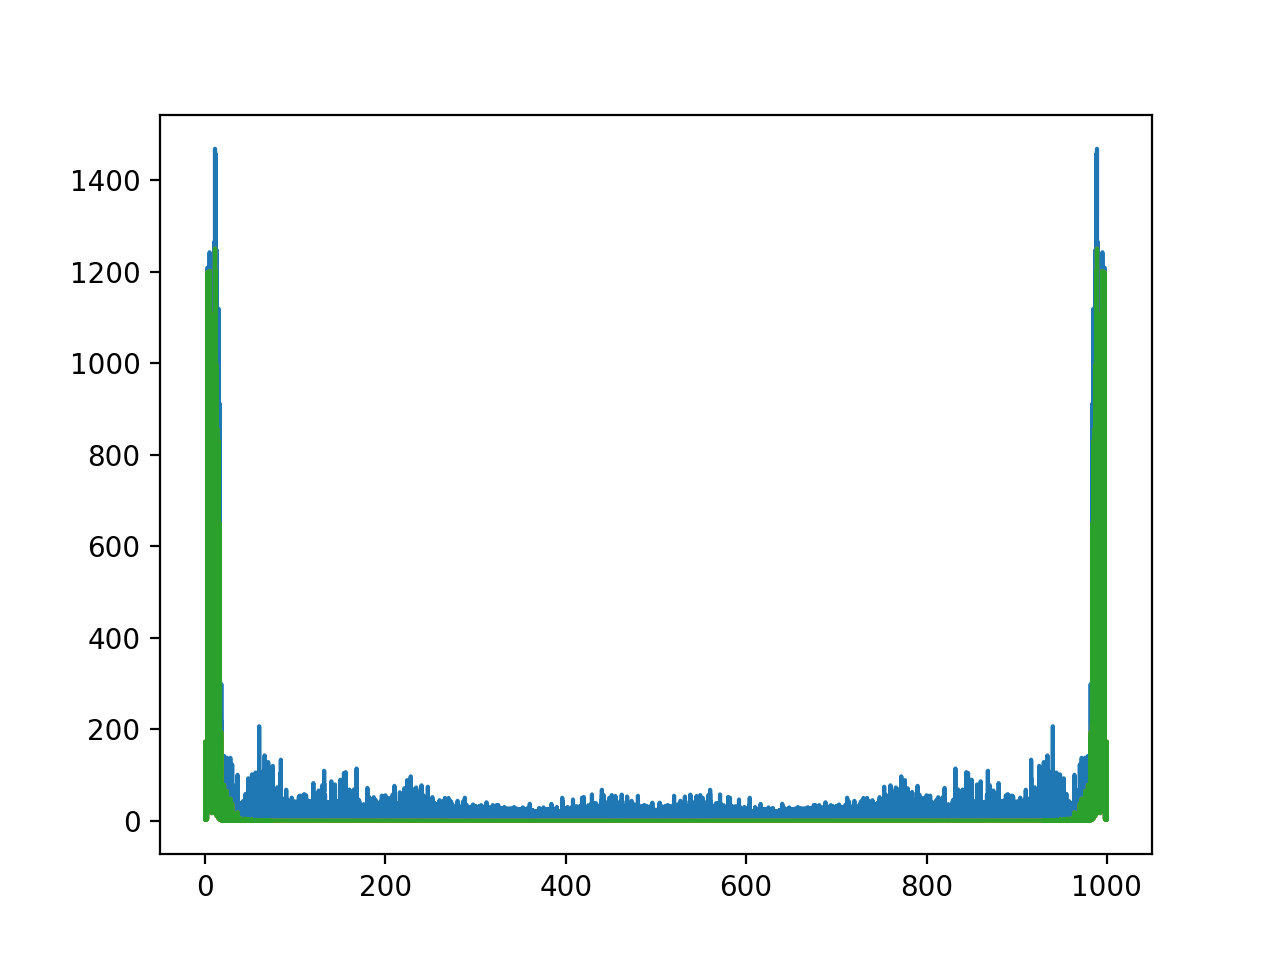

In [32]:
print(np.sum(np.abs(np.array(w_filt[0]))) - np.sum(np.abs(w_filt_sub[0])), dt, sub_dt)
plt.figure()
Y = myfft(w_slice[0], dt, True)
Y_filt = myfft(w_filt[0], dt, True)
Y_filt_sub = myfft(w_filt_sub[0].reshape(-1,), sub_dt, True)
plt.show()

In [33]:
# Save data with pickle
import os
import pandas as pd
df_u = pd.DataFrame(u_train.T)
df_theta = pd.DataFrame(theta_train.T)
df_w = pd.DataFrame(w_train.T)

save = True
folder = f'../../Data/Wandercraft_id/preprocessing/{start}-{end}-{step}difftraj_{sub_dt}subsampling_{N}samples_filter_{filter_type}{f_cut}_butteru'
if save:
    os.makedirs(folder, exist_ok=True)
    df_u.to_pickle(folder + '/data_u.pkl')
    df_theta.to_pickle(folder + '/data_theta.pkl')
    df_w.to_pickle(folder + '/data_w.pkl')
    specs_file = os.path.join(folder, 'Frequencies.txt')
    with open(specs_file, 'w') as f:
        print(fund_freqs, file=f)
print(df_w.shape)

(222891, 1)


(222891, 1)


<IPython.core.display.Javascript object>


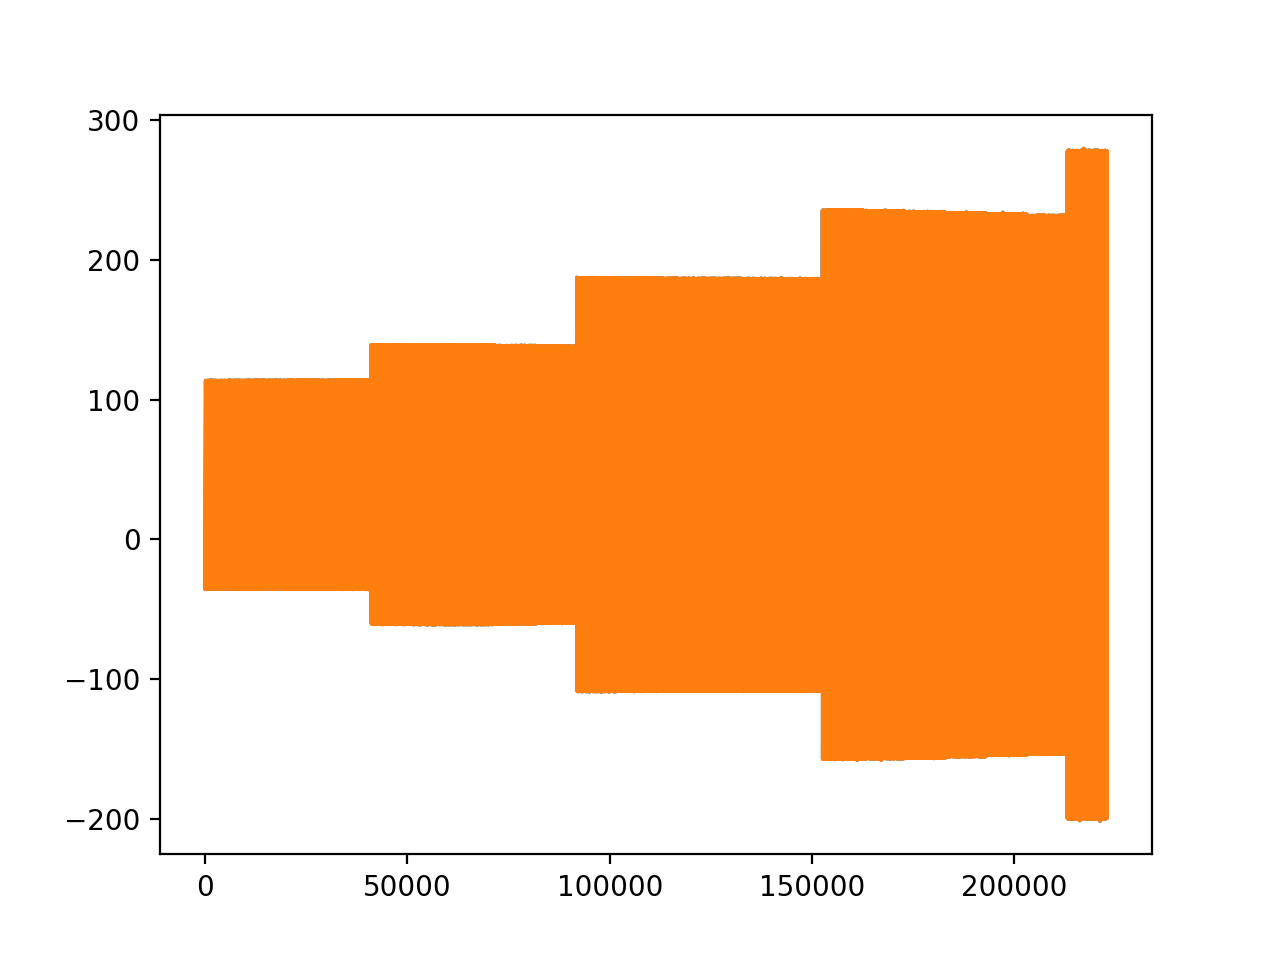

<IPython.core.display.Javascript object>


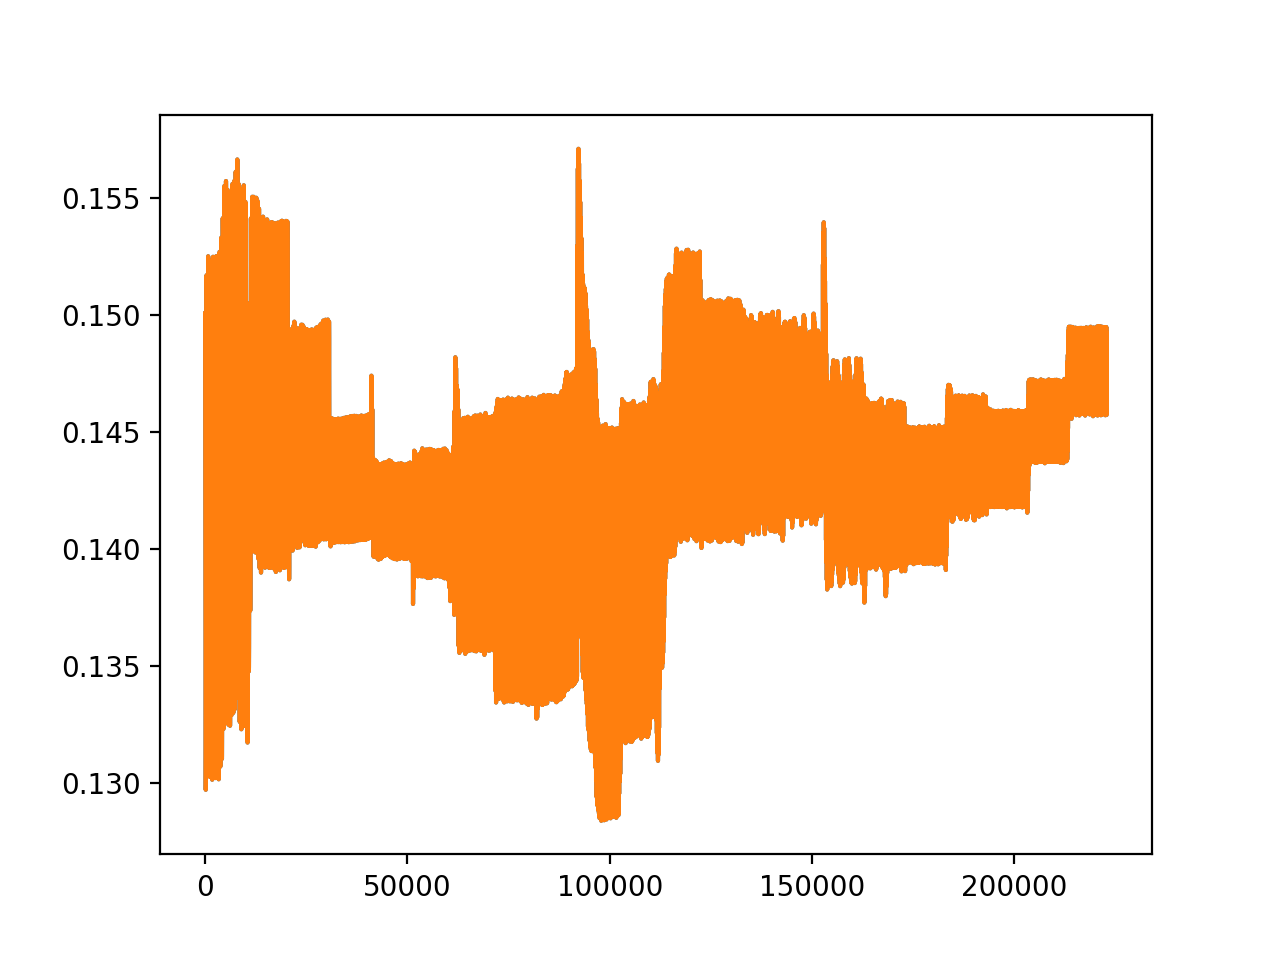

<IPython.core.display.Javascript object>


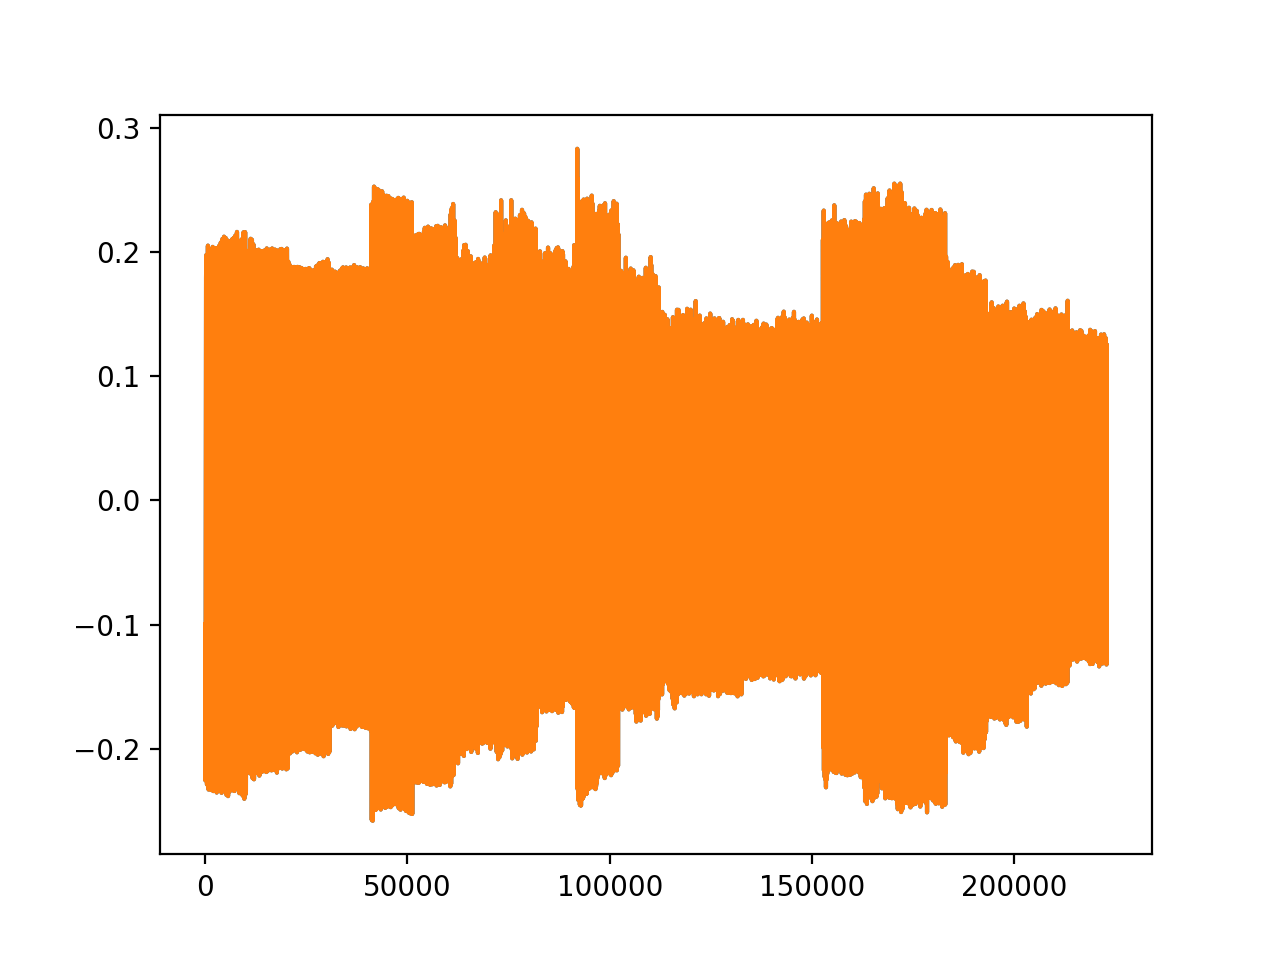

In [34]:
print(df_w.shape)
k = 0

plt.figure()
plt.plot(df_u.iloc[: , k])
plt.plot(u_train[k])
if save:
    plt.savefig(os.path.join(folder, 'u.pdf'), bbox_inches='tight')
plt.show()
plt.figure()
plt.plot(df_theta.iloc[: , k])
plt.plot(theta_train[k])
if save:
    plt.savefig(os.path.join(folder, 'theta.pdf'), bbox_inches='tight')
plt.show()
plt.figure()
plt.plot(df_w.iloc[: , k])
plt.plot(w_train[k])
if save:
    plt.savefig(os.path.join(folder, 'w.pdf'), bbox_inches='tight')
plt.show()